In [1]:
import networkx as nx
from networkx.generators.random_graphs import _random_subset
import sympy as sp
from sympy import symbols 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sympy.utilities.lambdify import lambdify


import copy
import time
import random as rd

In [2]:
G = nx.read_adjlist("BA.adjlist")
nodes = sorted([int(n) for n in G.nodes])

In [3]:
N = len(G.nodes)

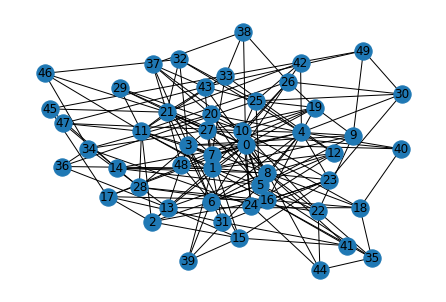

In [4]:
nx.draw(G, with_labels=True)    
plt.show()

In [5]:
adjacency = list(G.adjacency())

In [6]:
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)]

for a, b in adjacency :
    a = int(a)
    for c in b :
        c = int(c)
        A[a][c] = 1

In [7]:
seed = np.random.RandomState()
def dynamic_evolution(G, history = []):
    evolution = [0] * len(G.nodes)
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neighbours = list(G[n])
            new_node = _random_subset(neighbours, 1, seed).pop()
            evolution[int(new_node)] += 1
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[int(n)]
    history += [evolution]

In [8]:
walker_per_node = 200

In [9]:
long_history = [[]]
for h in range(len(long_history)):
    long_history[h] = [[walker_per_node] * len(G.nodes)]

In [10]:
time_steps = int(5e2)

In [11]:
t0 = time.time()

for h in range(len(long_history)):
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
        dynamic_evolution(G, long_history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 1 minutes and 51.15392017364502 seconds


In [12]:
index = []
for i in range(N):
    for j in range(i+1, N):
        if A[i][j] == 1:
            index += [(i,j)]

removed_link = index[rd.randint(0, len(index)-1)]
links = len(index) - 1

G.remove_edge(str(removed_link[0]), str(removed_link[1]))

In [13]:
print("It was removed the link between node", removed_link[0], "and node", removed_link[1])

It was removed the link between node 10 and node 29


In [14]:
A[removed_link[0]][removed_link[1]] = 0
A[removed_link[1]][removed_link[0]] = 0

In [15]:
t0 = time.time()

for h in range(len(long_history)):    
    for t in range(time_steps):
        dynamic_evolution(G, long_history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 1 minutes and 52.774558544158936 seconds


In [16]:
W = symbols(f'w:{links}')
print("There are", links, "indipendent weights")

There are 183 indipendent weights


In [17]:
count = 0
P = copy.deepcopy(A)
for i in range(N):
    for j in range(i+1, N):
        if P[i][j] == 1:
            P[i][j] = W[count]
            P[j][i] = W[count]
            count += 1

2* L'autovettore stazionario non coincide

In [18]:
with open("BA-pS.txt", "r") as file:
    pS = file.read()
    pS = pS.split("\n")
pS = [float(i) for i in pS]
pS = np.round(pS, 5)

In [19]:
e = (np.dot(pS, P) - pS)**2
E = e[0]
for i in range(1, len(e)):
    E += e[i]

1* Aggiungere la normalizzazione dei pesi alla funzione di costo fa ottenere molti autovettori vicini a 1 e l'autovettore stazionario non coincide con il valore atteso.

In [20]:
t0 = time.time()

my_func = lambdify(W, E)

def my_func_v(x):
    return my_func(*tuple(x))

# def cons1(x, i):
#     C = (sum(P[i])-1)**2
#     func = lambdify(W, C)
#     return func(*tuple(x))

# cons = ([{'type' : 'eq', 'fun': lambda x: cons1(x, i)} for i in range(len(P))])

x0 = [1/links]*links
# solution = minimize(my_func_v, x0, bounds = [[0, np.inf]]*len(x0), constraints=cons).x
result = minimize(my_func_v, x0, bounds = [[0, np.inf]]*len(x0), tol = 1e-6)
solution = result.x

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 0.5372843742370605 seconds


In [21]:
count = 0
P_new = copy.deepcopy(A)
for i in range(N):
    for j in range(i+1, N):
        if P_new[i][j] == 1:
            P_new[i][j] = solution[count]
            P_new[j][i] = solution[count]
            count += 1

2* l'autovettore stazionario non coincide con quello atteso

In [22]:
matrixP = np.array(P_new)

In [23]:
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)

In [24]:
diff = [np.abs(autovaloriP[i] - 1) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriP[i] - 1) == minDiff:
        pS_new = autovettoriP[i]
        print("Eigenvector found")
        break

np.round(autovaloriP.real, 4)

Eigenvector found


array([ 1.    , -0.6187,  0.5432, -0.5071,  0.4414, -0.4395, -0.4173,
       -0.4032, -0.3962, -0.3643,  0.3998,  0.3925,  0.3533,  0.3404,
        0.3254, -0.3244, -0.3095,  0.2677, -0.2563, -0.2419,  0.2149,
        0.2113, -0.1989, -0.1778, -0.1803,  0.1804, -0.1585,  0.1568,
        0.1421, -0.126 , -0.1124, -0.0999, -0.0829,  0.1184,  0.1076,
        0.0927,  0.0863, -0.0673,  0.0733, -0.0497, -0.0436, -0.0282,
        0.0508,  0.0432,  0.0327,  0.0198,  0.0131,  0.0076, -0.    ,
       -0.0109])

In [25]:
if pS_new[0] < 0:
    pS_new = -pS_new

In [26]:
pS_new = pS_new.real

In [27]:
for i in range(10):
    print(sum(P_new[i]))

2.0950231570170526
1.642151029452557
0.6271866380940152
1.0207101764407251
1.8355665046852354
1.568900462797917
0.5572935887726098
0.8051720024757002
1.6697645095008098
0.67819889667133


In [28]:
seed = np.random.RandomState()
def dynamic_evolution_after(G, P_new, history = []):
    evolution = [0]*N
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neightbours = []
            n = int(n)
            for ind in range(len(P_new[n])):
                if P_new[n][ind] != 0:
                    if len(neightbours) != 0:
                        neightbours += [[ind, P_new[n][ind] + neightbours[-1][1]]]
                    else:
                        neightbours += [[ind, P_new[n][ind]]]
            s = sum(P_new[n])
            prob = rd.uniform(0., s)

            for neigh, p in neightbours:
                if prob <= p:
                    evolution[neigh] += 1
                    break
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[int(n)]
    history += [evolution]

In [29]:
history = [[], [], []]
for h in range(len(history)):
    history[h] = [[walker_per_node] * len(G.nodes)]

In [30]:
t0 = time.time()

for h in range(len(long_history)):
    h = int(h)
    for t in range(time_steps):
        dynamic_evolution_after(G, P_new, long_history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 1 minutes and 59.897581815719604 seconds


In [31]:
time_steps = int(5e2)

In [32]:
t0 = time.time()

for h in range(len(history)):
    h = int(h)
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
        dynamic_evolution_after(G, P_new, history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 5 minutes and 5.107822418212891 seconds


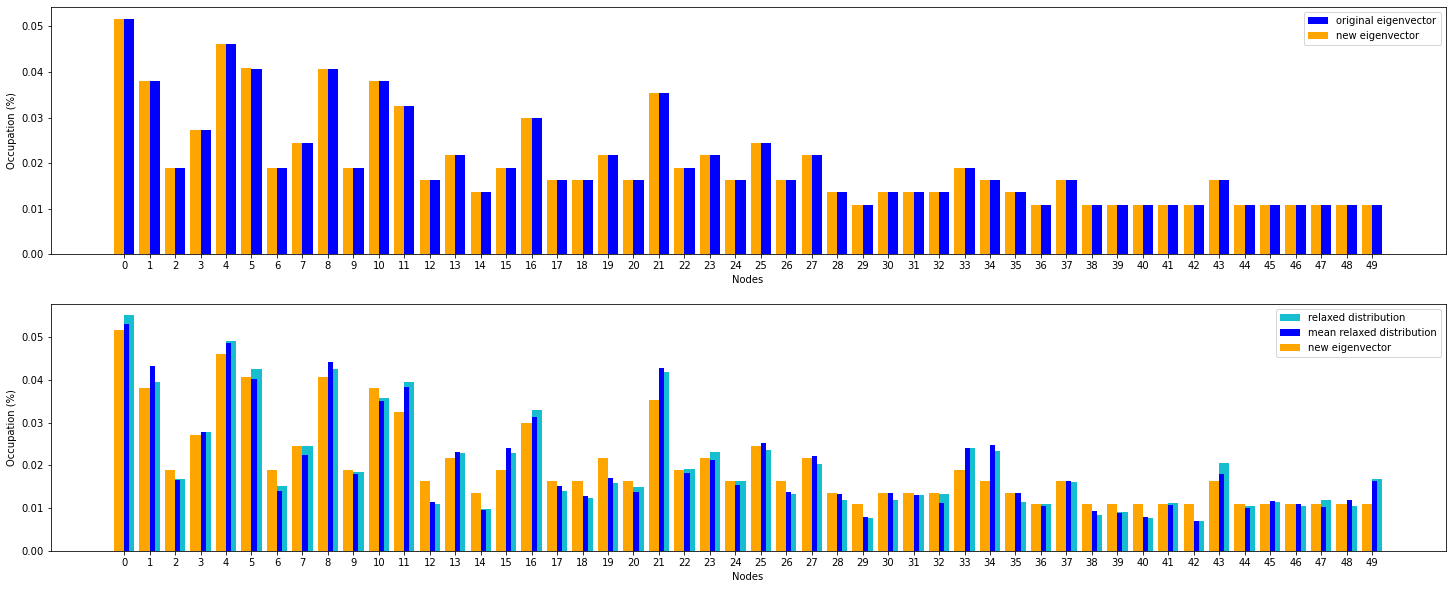

Solution found minimizing 50 equation in 183 variables


In [33]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(0.5*N, 10))

pSNorm = [h/sum(pS) for h in pS]
pSNorm_new = [h/sum(abs(pS_new)) for h in pS_new]

ax[0].bar(nodes, pSNorm, width=0.4, align='edge', color='blue', label="original eigenvector")
ax[0].bar(nodes, pSNorm_new, width=-0.4, align='edge', color='orange', label="new eigenvector")

hMean = [[(h1+h2+h3)/walker_per_node/N/3 
          for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] 
         for i in range(len(history[0]))]

ax[1].bar(nodes, [h/sum(history[0][-1]) for h in history[0][-1]], width=0.4, 
          align='edge', color='tab:cyan', label='relaxed distribution')
ax[1].bar(nodes, hMean[-1], width=0.2, align='edge', color='blue', label='mean relaxed distribution')
ax[1].bar(nodes, pSNorm_new, width=-0.4, align='edge', color='orange', label="new eigenvector")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Nodes")
    ax[i].set_ylabel("Occupation (%)")
    ax[i].set_xticks(np.arange(0, N, 1))
#     ax[i].grid(True)

plt.show()

print(f"Solution found minimizing {N} equation in {links} variables")

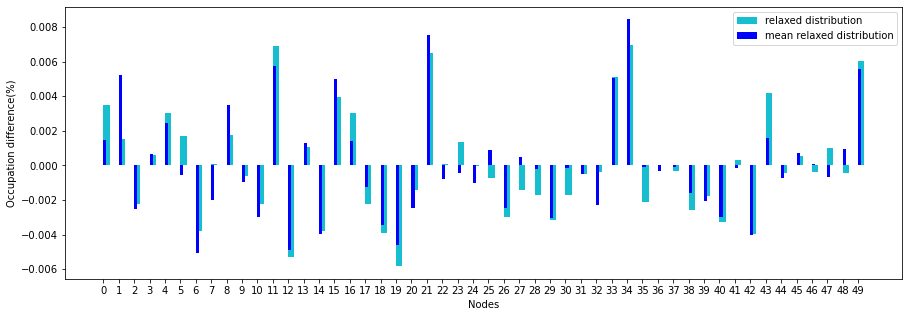

0.00023183205447038503


In [34]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.3*N, 5))

ax.bar(nodes, [h/sum(history[0][-1]) - k for h, k in zip(history[0][-1], pSNorm_new)], width=0.4, 
       align='edge', color='tab:cyan', label='relaxed distribution')
ax.bar(nodes, [h - k for h, k in zip(hMean[-1], pSNorm_new)],
       width=0.2, align='edge', color='blue', label='mean relaxed distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Occupation difference(%)")
ax.set_xticks(np.arange(0, N, 1))
# ax.grid(True)

plt.show()

print(sum([np.abs(h - k) for h, k in zip(hMean[-1], pSNorm_new)])/len(history[0]))

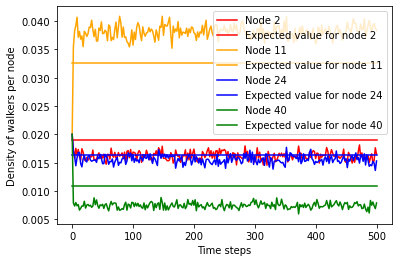

In [35]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
node = [2, 11, 24, 40]
color = ['red', 'orange', 'blue', 'green']

time_range = hMean
index = np.arange(0, len(time_range), 2)

col = 0
for i in node:
    ax.plot(index, [time_range[ind][i] for ind in index], label = f"Node {i}", color = color[col])
    ax.plot(index, [pSNorm_new[i]]*len(index), label = f"Expected value for node {i}", color = color[col])
    col += 1
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()

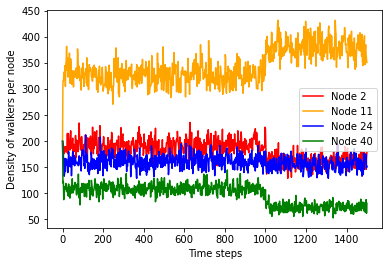

In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
node = [2, 11, 24, 40]
color = ['red', 'orange', 'blue', 'green']

time_range = long_history[0]
index = np.arange(0, len(time_range), 2)

col = 0
for i in node:
    ax.plot(index, [time_range[ind][i] for ind in index], label = f"Node {i}", color = color[col])
    col += 1
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()